In [41]:
from libraries import lib
import torch.nn as nn 
import torch
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class SimpleFFNet(nn.Module):
    """
    Feed forward neural network
    """

    # width: int
    # depth: int
    # nb_classes: int
    # emb_dim: int
    # activation: Callable[[Array], Array] = nn.selu

    @nn.compact
    def __call__(self, x: Array) -> Array:
        # embed the input
        x = nn.Embed(self.nb_classes, self.emb_dim, dtype=jnp.float64)(x.astype(int)).reshape(*x.shape[:-1], x.shape[-1] * self.emb_dim)
        # intermediate layers
        for _ in range(self.depth - 1):
            x = nn.Dense(self.width, dtype=jnp.float64)(x)
            x = self.activation(x)
        # last layer need to split to real and imaginary part
        r = nn.Dense(1, dtype=jnp.float64)(x).squeeze(axis=-1)
        i = nn.Dense(1, dtype=jnp.float64)(x).squeeze(axis=-1)
        return r + 1j * i

In [2]:
net = SimpleFFNet(width=32, depth=4, nb_classes=2, emb_dim=8, activation=nn.selu)

NameError: name 'SimpleFFNet' is not defined

In [42]:
N = 6; J = 1; Gamma = 1

In [64]:
layers = []
layers.append(nn.Linear(N, 32))
for _ in range(2):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.SELU())
layers.append(nn.Linear(32, 2))
model = nn.Sequential(*layers)

In [65]:
params = [n for n in model.parameters()]

In [69]:
params[0].grad

In [63]:
one = torch.tensor([lib.generate_state_1D(1, N)], dtype = torch.float32)
# input = torch.

In [53]:
print(model(one))
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * nn_output[:, 1])
print(log_amp_phase(model(one)))

tensor([[0.0837, 0.0827]], grad_fn=<AddmmBackward0>)
tensor([1.0835+0.0898j], grad_fn=<ExpBackward0>)


In [80]:
params = [n for n in model.parameters()]
x = log_amp_phase(model(one)).imag
x.backward()

In [77]:
torch.zeros(params[0].grad.clone().shape, requires_grad=True)

tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0

In [ ]:
import numpy.random as npr
import random

class SparseStateVector:
    """
    Container class for dictionary (self.values) with keys of integer states
    and values being complex amplitude of psi
    """
    def __init__(self):
        self.values = {}
        self.normalized = False

    def TFIM_multiply(psi, N, J, Gamma):
        """
        Returns new sparse vector representing H|psi>
        """
        prod = SparseStateVector()
        for state in psi.values:
            jtotal = 0
            for site in range(N - 1):
                jtotal += J if ((state >> site) ^ (state >> site + 1)) & 1 else -J
            jtotal += J if ((state >> (N - 1)) ^ (state >> 0)) & 1 else -J 
            prod.values[state] = jtotal * psi.values[state]
        
        for state in psi.values:
            for site in range(N):
                flipped_state = state ^ (1 << site)
                prod.values[flipped_state] = prod.values.get(flipped_state, 0) - Gamma * psi.values[state]
        return prod

    def inner_product(v1, v2):
        """
        Returns <v1|v2> for two SparseStateVectors
        """
        prod = 0
        for s in v1.values:
            if s in v2.values:
                prod += torch.conj(v1.values[s]) * v2.values[s]
        return prod

    def TFIM_expectation_from_sparse(psi, N, J, Gamma):
        """
        Returns <psi|H|psi>/<psi|psi> for SparseStateVector psi
        """
        # do H|psi> then <psi| (H|psi>)
        hpsi = SparseStateVector.TFIM_multiply(psi, N, J, Gamma)
        exp = SparseStateVector.inner_product(psi, hpsi)
        if not psi.normalized:
            mag2 = SparseStateVector.inner_product(psi, psi)
            return (exp / mag2).real
        return exp.real

    def normalize(self):
        """
        Normalizes values
        """
        mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
        for s in self.values:
            self.values[s] = self.values[s] / mag
        self.normalized = True

    def to_prob_distribution(self, N):
        """
        Returns 1D list representing real probability distribution
        """
        if not self.normalized:
            mag2 = sum(abs(self.values[s]) ** 2 for s in self.values)
            return [(abs(self.values.get(s, 0)) ** 2 / mag2).item() for s in range(0, 2 ** N)]
        return [abs(self.values.get(s, 0)) ** 2 for s in range(0, 2 ** N)]
    
    def to_dense_vector(self, N):
        """
        Returns 1D list of dense representation
        """
        if not self.normalized:
            mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
            return [(self.values.get(s, 0) / mag).item() for s in range(0, 2 ** N)]
        return [self.values.get(s, 0).item() for s in range(0, 2 ** N)]

class UniformNeuralState(SparseStateVector):
    def __init__(self, N, model, output_to_psi, num_samples):
        """
        Initializes sparse vector values

        Args:
            N (int): number of qubits
            model: torch model representing psi(x), which returns complex amplitude given integer state
            output_to_psi (function): takes in output of model to compute complex amplitude
            num_samples (int): number of unique integer samples to take
            informed (bool): whether to guarantee sample first and last states
        """
        super().__init__()
        self.samples = num_samples
        self.distribution = {}
        self.list = []
        self.nn_output = {}
        def psi(x):
            tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
            nn_output = model(tens)
            return output_to_psi(nn_output)[0], nn_output[0]
        if num_samples >= 2 ** N:
            for state in range(2 ** N):
                self.distribution[state] = 1
                self.list.append(state)
                self.values[state], self.nn_output[state] = psi(state)
        else:
            sampled_states = set()
            for _ in range(num_samples):
                x = random.getrandbits(N)
                while x in sampled_states:
                    x = random.getrandbits(N)
                sampled_states.add(x)
                self.distribution[x] = self.distribution.get(x, 0) + 1
                self.list.append(x)
            for state in sampled_states:
                self.values[state], self.nn_output[state] = psi(state)

class MHNeuralState(SparseStateVector):
    def __init__(self, N, model, output_to_psi, x_func, x0, num_samples, burnin = 0, lag = 0):
        """
        Initializes distribution of samples and vector values

        Args:
            N (int): number of qubits
            model: torch model representing psi(x), which returns complex amplitude given integer state
            output_to_psi (function): takes in output of model to compute complex amplitude
            x_func (function): takes in state x and generates proposal x*
            x0 (int): intger state to begin sampling
            num_samples (int): number of proposal x* generated
            burnin (int): number of samples to throw away before accepting first sample
            lag (int): number of samples to throw away in-between accepting samples
            informed (bool): whether to guarantee sample first and last states
        """
        # uses arbitrary x_func for MH sampling
        super().__init__()
        self.distribution = {}
        self.list = []
        self.nn_output = {}
        self.samples = num_samples
        def psi(x):
            tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
            nn_output = model(tens)
            return output_to_psi(nn_output)[0], nn_output[0]
        num_uniform = burnin + num_samples * (lag + 1)
        rand_uniform = npr.uniform(0, 1, num_uniform)
        index = 0

        x = x0
        psi_val, nn_val = psi(x)
        self.values[x] = psi_val
        self.nn_output[x] = nn_val
        for _ in range(burnin):
            new_x = x_func(x)
            new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
            ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
            if ratio > 1 or ratio > rand_uniform[index]:
                x = new_x
                psi_val = new_psi_val
            index += 1
        for _ in range(num_samples):
            for _ in range(lag):
                new_x = x_func(x)
                new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
                ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
                if ratio > 1 or ratio > rand_uniform[index]:
                    x = new_x
                    psi_val = new_psi_val
                index += 1
            new_x = x_func(x)
            if new_x in self.values: new_psi_val, new_nn_val = self.values[new_x], self.nn_output[new_x]
            else: new_psi_val, new_nn_val = psi(new_x)
            ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
            if ratio > 1 or ratio > rand_uniform[index]:
                self.distribution[new_x] = self.distribution.get(new_x, 0) + 1
                self.list.append(new_x)
                x = new_x 
                psi_val = new_psi_val 
            else: 
                self.distribution[x] = self.distribution.get(x, 0) + 1
                self.list.append(x)
            self.values[new_x] = new_psi_val
            self.nn_output[new_x] = new_nn_val
            index += 1


In [8]:
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x
# only for nn_output = (log(amp), phase)
def generate_eloc_list(sampled_vector, N, J, Gamma, model):
    nn_output_calcs = {}
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output

    eloc_values = []
    for basis_state in sampled_vector.list:
        eloc = 0
        output = model_to_output(basis_state)
        for adjacency in lib.generate_adjacencies(basis_state, N):
            output_prime = model_to_output(adjacency)
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * 2 * np.pi * (output_prime[1] - output[1]))
        eloc += lib.calc_H_elem(N, J, Gamma, basis_state, basis_state)
        eloc_values.append(eloc)
    return eloc_values

In [25]:
N = 4; J = 1; Gamma = 1

In [26]:
num_epochs = 1000
data_rate = 1
num_samples = 32

In [39]:
params[3]

Parameter containing:
tensor([ 0.1700, -0.0062, -0.1012,  0.1118, -0.1169,  0.1568, -0.1216, -0.0296,
        -0.0044,  0.0280, -0.1402, -0.0296,  0.1631, -0.1699, -0.0984, -0.1038,
         0.0753, -0.1486, -0.0551, -0.0224,  0.1301, -0.0671, -0.0648, -0.0894,
        -0.0495, -0.0855,  0.0813,  0.1231, -0.1174,  0.0752, -0.0593,  0.1445],
       requires_grad=True)

In [40]:
params = [n for n in model.parameters()]
params[1].grad = params[3]

In [60]:
layers = []
layers.append(nn.Linear(N, 32))
for _ in range(2):
    layers.append(nn.Linear(32, 32))
    layers.append(nn.SELU())
layers.append(nn.Linear(32, 2))
model = nn.Sequential(*layers)

epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    print(eloc_list, eloc_list.mean())
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    # loss = generate_eloc_list(MHNeuralState(N, model, log_amp_phase,
    #                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples),
    #                                           N, J, Gamma, model)
    # loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, log_amp_phase, 
    #                                                        lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
    #                                                        N, J, Gamma, model, log_amp_phase) # this works Gamma = 10
    # print('x', loss, energy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

tensor([ -7.6654-0.9277j,  -7.4690+0.6349j, -11.5937+0.9331j,  -7.5764+1.6204j,
         -7.5936+1.6987j,  -7.6651+0.9157j,  -7.4616+1.5049j,  -3.7246+0.4468j,
         -7.7819-1.0919j,  -3.8070-0.9504j,  -3.7097+0.5702j,  -3.7246+0.4468j,
         -3.7097+0.5702j,  -7.7668-0.3392j,  -7.6160+0.1569j,  -7.6560+0.0494j,
         -7.7267-1.1046j,  -7.6560+0.0494j,  -7.7267-1.1046j,  -7.6560+0.0494j,
         -7.4691+0.6984j,  -7.4135+1.6729j,  -7.5936+1.6987j,  -3.6051+0.5737j,
         -3.7765-0.5765j,  -3.7166+0.8701j,  -3.7641+0.5514j,  -7.7648-1.0551j,
         -7.6888+0.2301j,  -7.5273-0.3524j,  -7.4616+1.5049j,  -7.6651+0.9157j]) tensor(-6.6479+0.3394j)
0 tensor(-6.6479+0.3394j) 0.00208439864218235
tensor([ -3.6438+0.2307j,  -7.6901-0.5872j,  -7.9185-1.1275j,  -7.8300-0.3047j,
         -3.7894+0.5394j,  -7.8300-0.3047j,  -3.8800-0.0045j,  -3.8663-0.8035j,
         -7.9185-1.1275j,  -7.6901-0.5872j,  -7.7245-0.8944j,  -7.6016-0.3825j,
         -3.5376-0.3173j,   0.5167+0.1016j,  -3.5

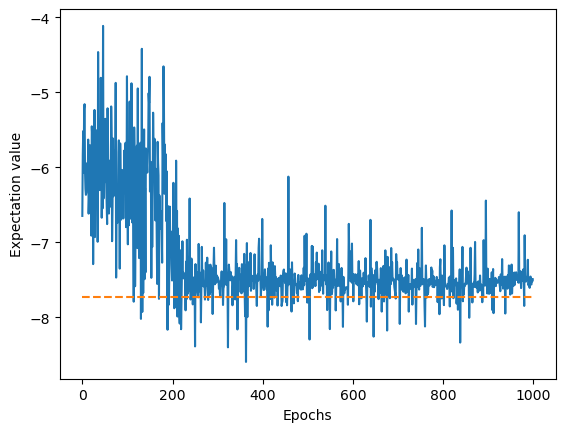

In [61]:
# ground state energy about -10N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [lib.ground_state_energy(1, N)] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [ ]:
lib.ground_state_energy(1, N)

np.float64(-7.727406610312546)

In [14]:
lib.TFIM_hamiltonian(6, 1, 1).eigenstates()[0][0]

np.float64(-7.727406610312534)